<a href="https://colab.research.google.com/github/SvetlanaErmakova/Analytics-and-statistics/blob/main/food_delivery(one_way_anova).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В компании по доставке готовых блюд проведен тест:

Разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные1, либо прямоугольные2, либо квадратные

Проведем статистические тесты и сделаем выводы о влиянии этих 3ех уровней фактора на количество заказов:

1.Проверим, являются ли дисперсии внутри групп гомогенными

2.Проведем тест на нормальность распределения

3.Сравним средние в представленных группах - anova

4.Проведем попарные сравнения

5.Сделаем вывод





Описание данных:

•	id – id клиента в эксперименте

•	group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)

•	events – сколько блюд суммарно было заказано за период



In [ ]:
!pip install pingouin

In [ ]:
import pandas as pd
import numpy as np

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(rc = {'figure.figsize': (12, 6)}, style = "whitegrid")

In [ ]:
exp1 = pd.read_csv("test_format.csv")
exp1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


##1.	Проверим, являются ли дисперсии внутри групп гомогенными.

In [ ]:
exp1.group.nunique()

3

In [ ]:
exp1.groupby("group").size() #.agg({'events':"count"})

group
A    10000
B    10000
C    10000
dtype: int64

In [ ]:
pg.homoscedasticity(data = exp1, dv = "events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


##2. Проведем тест на нормальность распределения

In [ ]:
pg.normality(data = exp1, dv = "events", group="group", method="normaltest")

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


In [ ]:
pg.normality(data = exp1, dv = "events", group="group", method="shapiro") #плохо для больших выборок, а размер выборки: 10000

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
group,,,
A,0.998933,0.000004,False
B,0.999016,0.000011,False
C,0.998920,0.000003,False


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

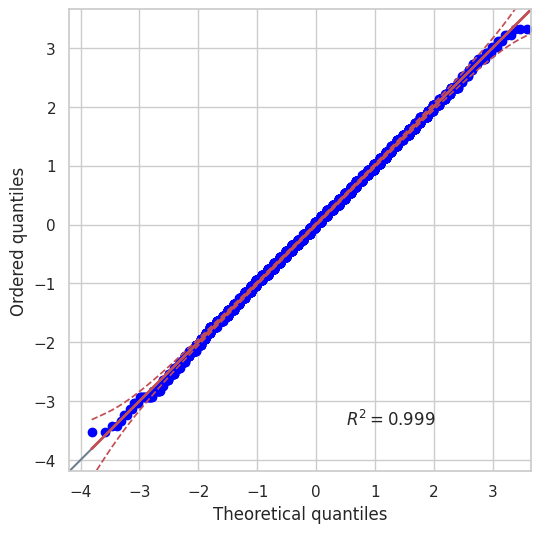

In [ ]:
pg.qqplot(exp1.query("group == 'A'").events)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

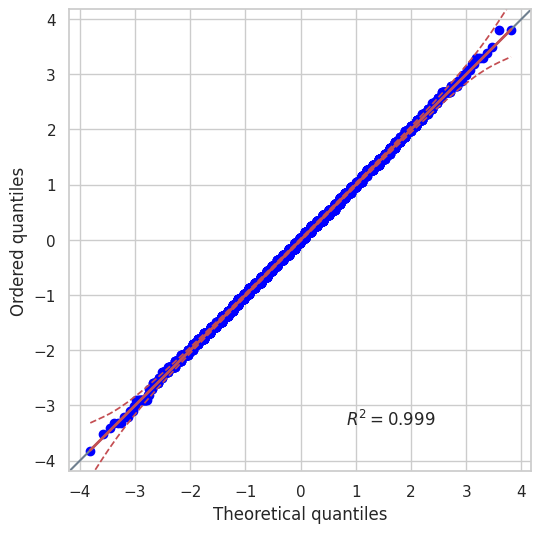

In [ ]:
pg.qqplot(exp1.query("group == 'B'").events)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

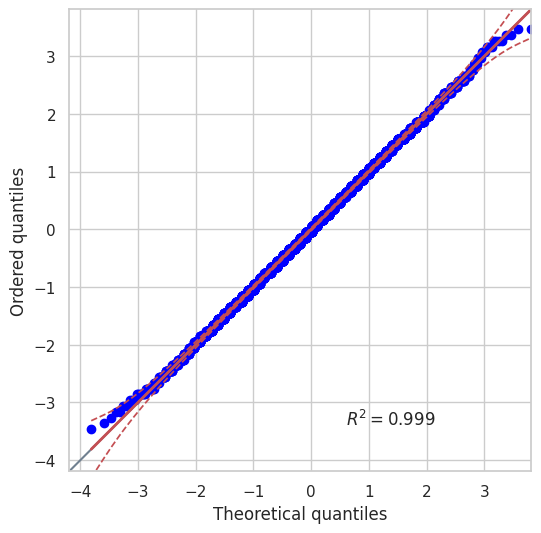

In [ ]:
pg.qqplot(exp1.query("group == 'C'").events)

##3.	Сравним средние в представленных группах - anova

scipy:

In [ ]:
st.f_oneway(exp1.query("group == 'A'").events, exp1.query("group == 'B'").events,\
            exp1.query("group == 'C'").events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

pingouin:

In [ ]:
pg.anova(data = exp1, dv = "events", between = "group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


##4. Проведем попарные сравнения (anova: отвергли Н0 - те различия есть)

Критерий Тьюки из statsmodels:

In [ ]:
MultiComp = MultiComparison(exp1["events"], groups = exp1["group"])

In [ ]:
MultiComp.tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.0,7.7038,8.3642,True
A,C,-2.1093,0.0,-2.4395,-1.7791,True
B,C,-10.1433,0.0,-10.4735,-9.8131,True


Нарисуем:

<Axes: xlabel='group', ylabel='events'>

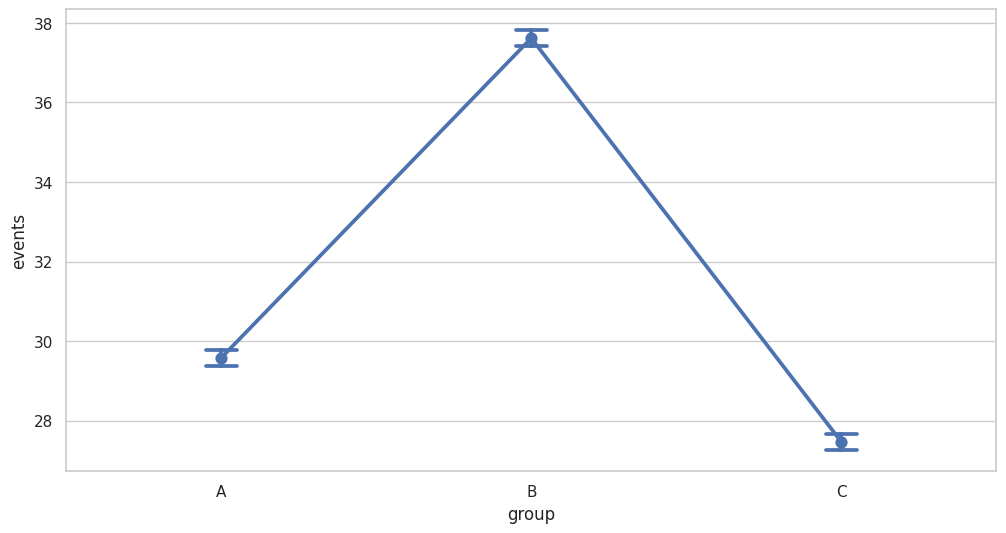

In [ ]:
sns.pointplot(x = 'group', y = 'events', data = exp1, capsize = 0.1)

pingouin:

In [ ]:
pg.pairwise_tukey(data = exp1, dv = "events", between = "group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


Если нас волнует неравенство дисперсий:

In [ ]:
pg.pairwise_gameshowell(data = exp1, dv = "events", between = "group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,6.349254e-12,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


t-тест и зададим поправку руками:

In [ ]:
pg.pairwise_ttests(data = exp1, dv = "events", between = "group", padjust="bonf")

/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/usr/local/lib/python3.10/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)
/usr/local/lib/python3.10/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


##5. Сделаем вывод

Итого: провели однофакторный anova, поняли что формат влияет на количество лайков и разобрались, что вариант формата "B" - наилучший, тк он дает наибольший прирост в лайках.